In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import FashionMNIST
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
epochs = 30
batch_size = 100
img_size = 28
img_dim = img_size*img_size
img_channels = 1
n_class = 10
z_dim = 2
lr = 3e-4

In [5]:
trainData = FashionMNIST(root='./Fashion_VAE_GAN/data', 
                  train = True, 
                  download= True, 
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize([0.5],[0.5])])
                  )
n_sample = len(trainData)
# print(n_sample)
train_loader = DataLoader(dataset=trainData,
                          shuffle= True,
                          batch_size= batch_size)
for imgs, label in train_loader:
    print('imgs_batch_shape = ',imgs.shape)
    break

100%|██████████| 26.4M/26.4M [00:21<00:00, 1.23MB/s]


Extracting ./Fashion_VAE_GAN/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./Fashion_VAE_GAN/data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 148kB/s]


Extracting ./Fashion_VAE_GAN/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./Fashion_VAE_GAN/data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.63MB/s]


Extracting ./Fashion_VAE_GAN/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./Fashion_VAE_GAN/data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.15MB/s]

Extracting ./Fashion_VAE_GAN/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./Fashion_VAE_GAN/data\FashionMNIST\raw

imgs_batch_shape =  torch.Size([100, 1, 28, 28])


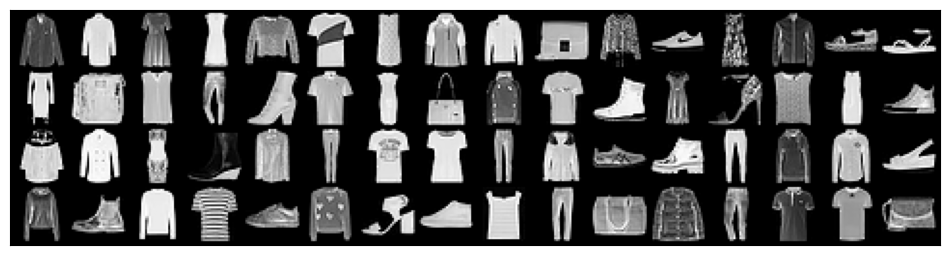

In [6]:
#Visualize
def denorm(img_tensors):
    return img_tensors*0.5+0.5
def show_imgs(imgs):
    fig,ax =plt.subplots(figsize = (12,8))
    input = make_grid(denorm(imgs[:64]), nrow=16, padding=2)
    ax.imshow(input.permute(1,2,0), cmap= 'gray')
    ax.set(xticks =[], yticks = [])
    plt.show()
show_imgs(imgs)

In [7]:
def weight_init(m):
    if (type(m)== nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
def conBL(n_in, n_out, f=4, s=1, p=1):
    return nn.Sequential(nn.Conv2d(n_in,n_out, kernel_size=f,stride=s,
                                   padding=p,bias = False),
                                   nn.BatchNorm2d(n_out),
                                   nn.LeakyReLU(0.2, inplace=True))
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            conBL(img_channels, 64, f=4, s=2, p=1),
            conBL(64,128, f=4, s=2, p=2),
            conBL(128, 256, f=4, s=2, p=1)
        )
        self.mu = nn.Conv2d(256, z_dim, 4, 1, 0, bias = False)
        self.logvar = nn.Conv2d(256, z_dim, 4, 1, 0)
    def forward(self, images):
        output = self.net(images)
        mu = self.mu(output).squeeze()
        logvar = self.logvar(output).squeeze()
        std = torch.exp(0.5*logvar)
        z = mu + std*torch.rand_like(std)
        return z, mu, logvar
Q = Encoder().cuda()
Q.apply(weight_init)

Encoder(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (mu): Conv2d(256, 2, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (logvar): Conv2d(256, 2, kernel_size=(4, 4), stride=(1, 1))
)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(img_channels, 32, 4, 2, 1),
                                 nn.LeakyReLU(0.2, inplace= True),
                                 conBL(32, 64, 4, 2, 2),
                                 conBL(64, 128, 4, 2, 1),
                                 conBL(128, 256, 2, 2, 0))
        self.scalar = nn.Sequential(
            nn.Conv2d(256, img_channels, 2, 1, 0),
            nn.Flatten(),
            nn.Sigmoid()
        )
    def forward(self,images):
        output = self.net(images)
        scalars = self.scalar(output)
        return scalars, output.view(-1,256*2*2)
D = Discriminator().cuda()
D.apply(weight_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (scalar): Sequential(
    (0): Conv2d(256, 1, kernel_siz

In [10]:
def basic_P(n_in, n_out, f= 4, s=2, p=1):
    return nn.Sequential(
        nn.ConvTranspose2d(n_in, n_out, f, s, p),
        nn.BatchNorm2d(n_out),
        nn.ReLU(True)
    )

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            basic_P(z_dim, 256, 4, 1, 0),
            basic_P(256, 128, 3, 2, 1),
            basic_P(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias = True),
            nn.Tanh()
        )
    def forward(self,z):
        input = z.view(-1, z_dim, 1, 1)
        output = self.net(input)
        return output
P = Decoder().cuda()
P.apply(weight_init)

Decoder(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(2, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)

In [11]:
criterion = nn.BCELoss(reduction= 'sum') #For D
loss = nn.MSELoss(reduction='sum') #For P and Q
optimizer_Q = torch.optim.RMSprop(Q.parameters(),lr=lr)
optimizer_P = torch.optim.RMSprop(P.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(D.parameters(),lr=10*lr)

In [12]:
def loss_gan(inputs, z): #GAN loss, inputs are real images, z comes from Q
    batch_size = inputs.shape[0] 
    preds_real = D(inputs)[0] # scalars of real images from model D 
    one_targets = torch.ones(batch_size, 1, device='cuda') 
    loss_real = criterion(preds_real, one_targets) #BCELoss for real images 
    pred_fake = D(P(z))[0]
    zero_targets = torch.zeros(batch_size, 1, device='cuda') 
    loss_fake = criterion(pred_fake, zero_targets) #BCELoss for fake images 
    z_p = torch.randn(batch_size, z_dim, device='cuda') #samples from N(0,I) 
    x_p = P(z_p) 
    pred_x_p =D(x_p)[0] 
    loss_noises = criterion(pred_x_p, zero_targets) #BCELoss for noise z_p 
    loss_gan = loss_real + loss_fake + loss_noises 
    return loss_gan

def loss_rec(inputs, z): 
#Reconstruction loss
    pixel_real = D(inputs)[1] 
    pixel_fake = D(P(z))[1] 
#rec_loss =((pixel_real - pixel_fake)**2).sum() 
    rec_loss = 0.5*loss(pixel_real, pixel_fake) 
    return rec_loss

  0%|          | 0/30 [00:00<?, ?it/s]

Dkl =  67.87930297851562
Epoch = 1, D_loss: 51.0603, loss_P: 0.0000, loss_Q: 0.0000


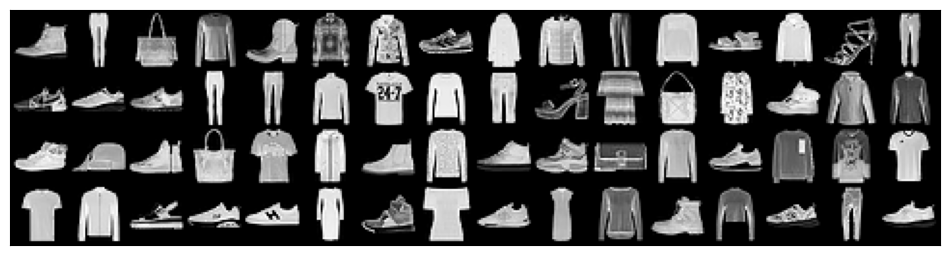

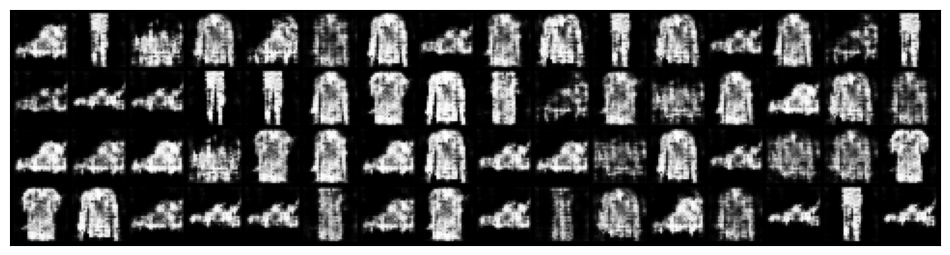

 13%|█▎        | 4/30 [07:04<46:04, 106.35s/it]

Dkl =  42.11840057373047
Epoch = 5, D_loss: 74.9579, loss_P: 0.0000, loss_Q: 0.0000


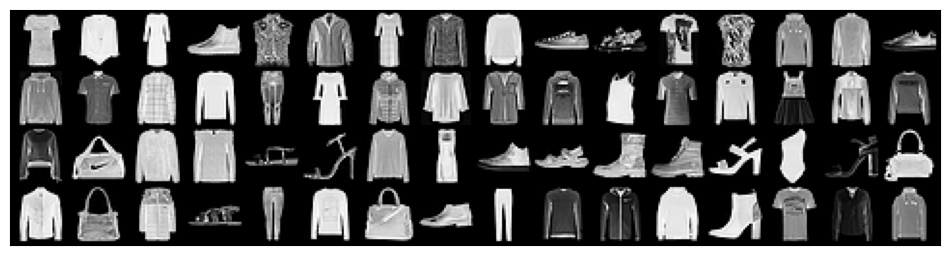

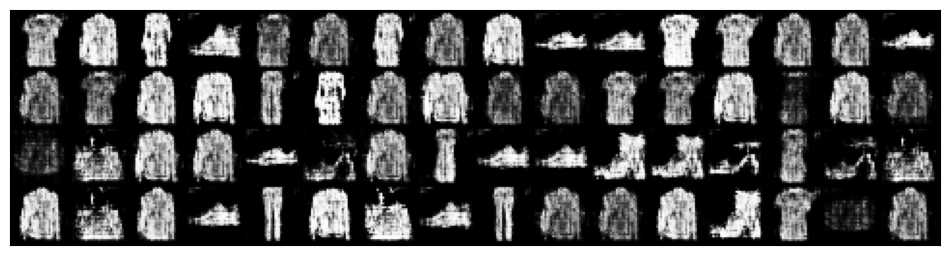

 30%|███       | 9/30 [15:53<36:59, 105.71s/it]

Dkl =  41.11294174194336
Epoch = 10, D_loss: 66.6640, loss_P: 0.0000, loss_Q: 0.0000


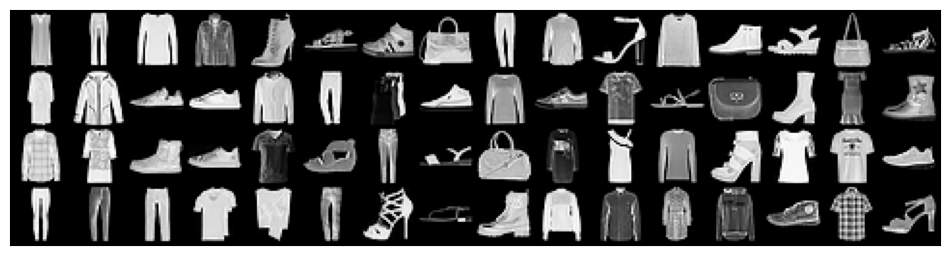

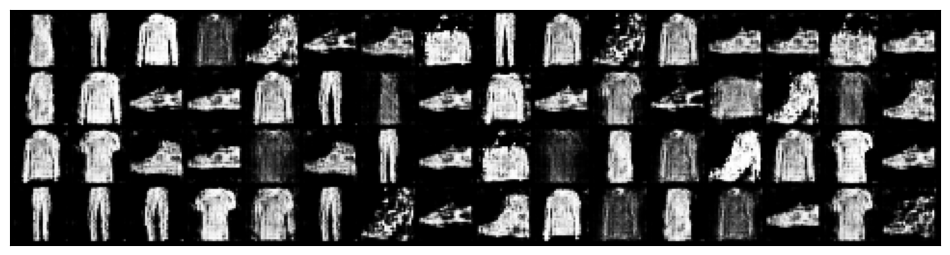

 47%|████▋     | 14/30 [24:42<28:14, 105.90s/it]

Dkl =  38.23581314086914
Epoch = 15, D_loss: 67.5531, loss_P: 0.0000, loss_Q: 0.0000


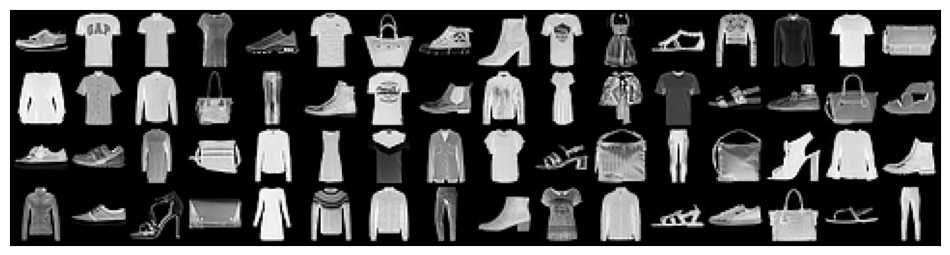

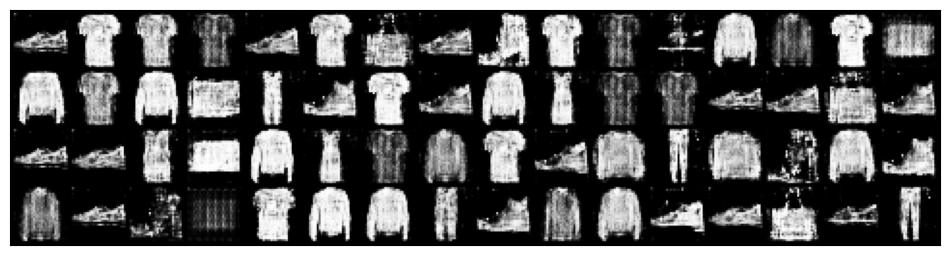

 63%|██████▎   | 19/30 [39:36<36:05, 196.84s/it]

Dkl =  40.214847564697266
Epoch = 20, D_loss: 62.6380, loss_P: 0.0000, loss_Q: 0.0000


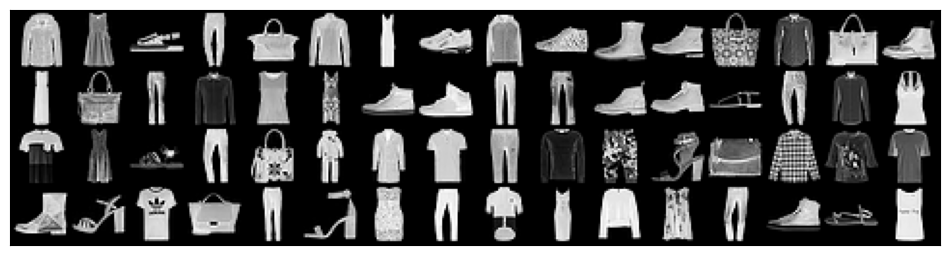

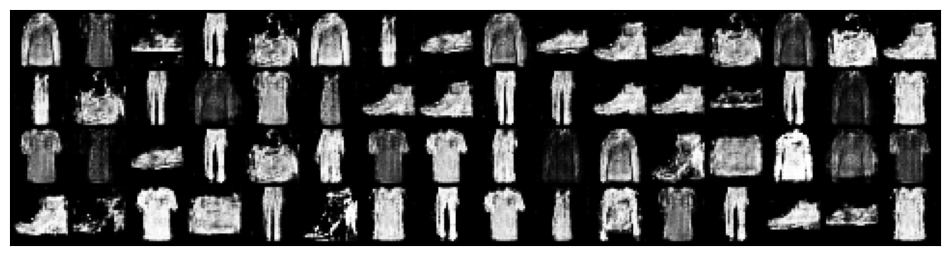

 80%|████████  | 24/30 [55:13<16:46, 167.67s/it]

Dkl =  41.73741149902344
Epoch = 25, D_loss: 60.2515, loss_P: 0.0000, loss_Q: 0.0000


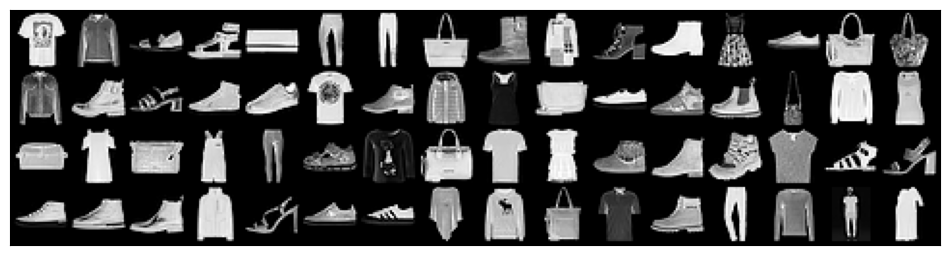

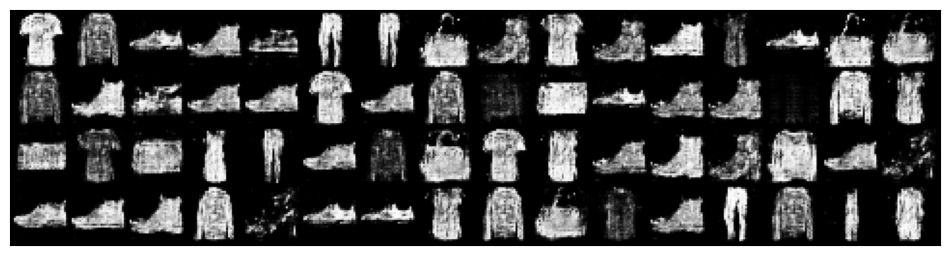

 97%|█████████▋| 29/30 [1:03:59<01:55, 115.69s/it]

Dkl =  35.84811019897461
Epoch = 30, D_loss: 62.2149, loss_P: 0.0000, loss_Q: 0.0000


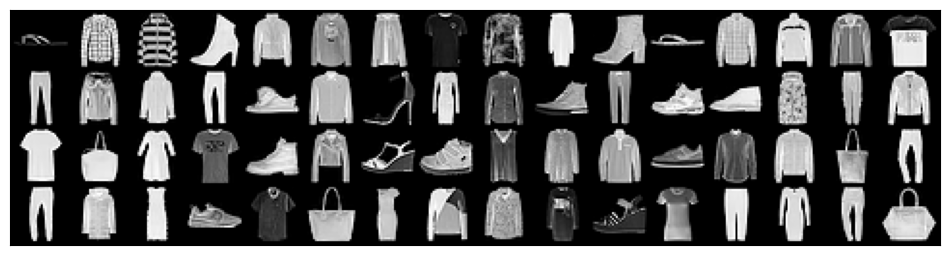

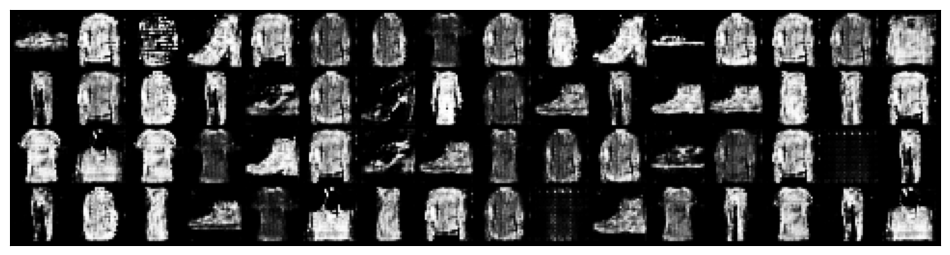

100%|██████████| 30/30 [1:05:45<00:00, 131.50s/it]


In [18]:
def fit(epochs):
    torch.cuda.empty_cache()
    df = pd.DataFrame(np.empty([epochs, 3]), 
                      index = np.arange(epochs), 
                      columns=['D_loss', 'P_loss', 'Q_loss']) 
    for i in trange(epochs):
        loss_q = 0.0; loss_d = 0.0; loss_p = 0.0
        for real_imgs, _ in train_loader:
            inputs = real_imgs.cuda()
            z, mu, logvar = Q(inputs)
            D_loss = loss_gan(inputs,z)
            loss_d += D_loss.item()
            optimizer_D.zero_grad()
            D_loss.backward(retain_graph = True)
            optimizer_D.step()

            D_loss = loss_gan(inputs,z)
            rec_loss = loss_rec(inputs, z)
            P_loss = rec_loss - D_loss
            loss_p += P_loss.item()
            optimizer_P.zero_grad()
            # torch.autograd.set_detect_anomaly(True)
            P_loss.backward(retain_graph = True)
            optimizer_P.step()

            Dkl = mu.pow(2) + logvar.exp() - logvar - 1
            prior_loss = torch.mean(Dkl)
            rec_loss =loss_rec(inputs, z)
            Q_loss = rec_loss + prior_loss # --Encoder Loss
            loss_q += Q_loss.item()
            optimizer_Q.zero_grad()
            Q_loss.backward(retain_graph = True)
            optimizer_Q.step()
        df.iloc[i,0] = loss_d/n_sample
        df.iloc[i,0] = loss_p/n_sample
        df.iloc[i,0] = loss_q/n_sample
        if i == 0 or (i+1)%5 == 0:
            print('Dkl = ', prior_loss.item())
            print(
                'Epoch = {}, D_loss: {:.4f}, loss_P: {:.4f}, loss_Q: {:.4f}'
                .format(i+1, df.iloc[i,0], df.iloc[i,1], df.iloc[i,2])
            )
            show_imgs(real_imgs)
            fake_images = P(z)
            show_imgs(fake_images.detach().cpu())
    return df

train_history = fit(epochs=epochs)

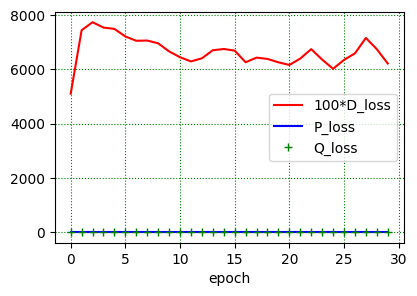

In [19]:
df = train_history.copy() 
df.iloc[:,0] =100*df.iloc[:,0]
fig, ax = plt.subplots(figsize=(4.5,3))
#history.plot(ax=ax, style=[, '+'], color=['r','b','g']) 
df.columns=['100*D_loss', 'P_loss', 'Q_loss'] 
df.plot(ax=ax, style=['-','-', '+'], color=['r','b','g']) 
ax.grid(which='major', axis='both', color='g', linestyle=':') 
ax.set(xlabel='epoch')#, ylim=[0, 800]) 
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_26364\912636927.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  z[i*m: (i+1)*m]= label


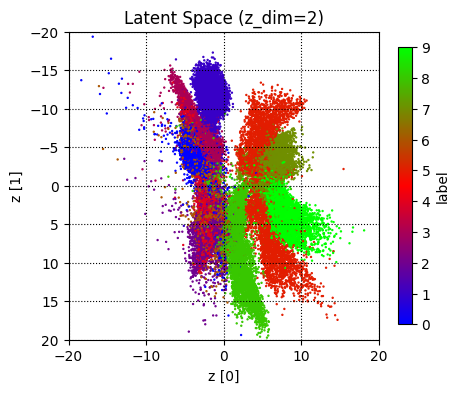

In [21]:
torch.cuda.empty_cache()
D.eval()
x= np.empty(n_sample); y= np.empty(n_sample); z= np.empty(n_sample)

for i, (img, label) in enumerate(train_loader): 
    m = len(label) 
    real_img = img.cuda() 
    latent,_,_ = Q(real_img)
    logits = latent.squeeze().detach().cpu() 
    x[i*m: (i+1)*m]= logits[:,0].numpy() 
# z[0]=x
 # z[l]=y
    y[i*m: (i+1)*m]= logits[:,1].numpy() 
    z[i*m: (i+1)*m]= label
fig, ax = plt.subplots(figsize=(5,4)) 
plt.scatter(x=x,y=y,c=z,s=0.5,cmap="brg")
ax.grid(which='major', axis='both', color='k', linestyle=':')
ax.set(xlabel = 'z [0]', ylabel = 'z [1]', ylim=[-20, 20], xlim=[-20, 20], 
       title ='Latent Space (z_dim=2)')
ax.invert_yaxis()
cbar = plt.colorbar(label="label", orientation="vertical",shrink=0.9)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10)) 
plt.show()